# Model Validation

I want to check if my model is working well before I proceed with sentiment analysis.

This is an unsupervised model, so I will have to manually sample, label, and verify.

In [220]:
import bbcode
import re
import string
import spacy
from spacy_langdetect import LanguageDetector
import json

import nltk
from nltk import WordNetLemmatizer

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import steamreviews
import datetime

In [3]:
#initialise model and dataset

#load dataset, which was previously cleaned in Modelling 3rd Run
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/model2/model2.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open

In [4]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.023*"three_kingdoms" + 0.023*"series" + 0.021*"fan" + 0.020*"diplomacy" + 0.020*"battle" + 0.018*"love" + 0.018*"best_total_war" + 0.017*"campaign" + 0.014*"total_war_games" + 0.014*"fun" + 0.014*"character" + 0.014*"shogun" + 0.014*"play" + 0.011*"title" + 0.009*"gameplay"')

(1, '0.025*"china" + 0.021*"war" + 0.021*"cao_cao" + 0.019*"lu_bu" + 0.016*"liu_bei" + 0.016*"yuan_shao" + 0.014*"army" + 0.011*"character" + 0.011*"man" + 0.010*"emperor" + 0.010*"warlord" + 0.010*"friend" + 0.010*"history" + 0.009*"faction" + 0.009*"sun_jian"')

(2, '0.037*"faction" + 0.027*"army" + 0.024*"diplomacy" + 0.016*"vassal" + 0.015*"war" + 0.014*"player" + 0.013*"people" + 0.012*"way" + 0.011*"city" + 0.011*"problem" + 0.011*"campaign" + 0.010*"option" + 0.009*"spy" + 0.009*"three_kingdoms" + 0.009*"review"')

(3, '0.053*"unit" + 0.035*"battle" + 0.026*"faction" + 0.023*"army" + 0.022*"general" + 0.022*"character" + 0.013*"diplomacy" + 0.013*"campaign" + 0.011*"hero" + 0.010*"building" + 0.010*

In [5]:
model2_df.head()

,review,clean_reviews,2gram_reviews,3gram_reviews,2gram_reviews_v2,3gram_reviews_v2
0,Well for me game still tons of work. i like it...,"['tons', 'work', 'recommend', 'one', 'diplomac...","['ton', 'diplomacy', 'joke', 'military_access'...","['ton', 'diplomacy', 'joke', 'military_access'...","['ton', 'diplomacy', 'joke', 'military_access'...","['ton', 'diplomacy', 'joke', 'military_access'..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"['pursued', 'lu', 'bu', 'lu', 'bu']","['lu_bu', 'lu_bu']","['lu_bu', 'lu_bu']","['lu_bu', 'lu_bu']","['lu_bu', 'lu_bu']"
2,Absolutely great game. \nAll the new diplomacy...,"['absolutely', 'new', 'diplomacy', 'options', ...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',...","['diplomacy_options', 'depth', 'unit_variety',..."
3,A fine blend of Warhammer I/II: Total War and ...,"['fine', 'blend', 'warhammer', 'three', 'total...","['blend', 'total_war', 'shogun_two', 'total_wa...","['blend', 'warhammer_three', 'total_war', 'sho...","['blend', 'shogun_two', 'love', 'hour', 'hero'...","['blend', 'warhammer_three', 'shogun_two', 'lo..."
4,Innovative Total Game that has lots of persona...,"['innovative', 'total', 'lots', 'personality',...","['personality', 'diplomacy', 'idea', 'combat',...","['personality', 'diplomacy', 'idea', 'combat',...","['personality', 'diplomacy', 'idea', 'combat',...","['personality', 'diplomacy', 'idea', 'combat',..."


In [6]:
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again to get lists of terms
model2_df['clean_reviews'] = model2_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) #n-grams underscores must be preserved for readability
model2_df['2gram_reviews'] = model2_df['2gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
model2_df['2gram_reviews_v2'] = model2_df['2gram_reviews_v2'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
model2_df['3gram_reviews'] = model2_df['3gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
model2_df['3gram_reviews_v2'] = model2_df['3gram_reviews_v2'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 

In [7]:
documents = list(model2_df['3gram_reviews_v2'])
dictionary = gensim.corpora.Dictionary(documents)

#IMPORTANT! If you filtered extremes when CREATING the model, you must give it back EXACTLY the same dictionary or else it won't be able to work with lda_model[corpus]!
#Learned this the hard way when coding this the first time.
dictionary.filter_extremes(no_below = 5,no_above=0.5)     

corpus = [dictionary.doc2bow(text) for text in documents]

In [57]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [58]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Series Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'Game Stability',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.Series(model2_df['review'])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [59]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [60]:
# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens','original_text']

df_dominant_topic['num_tokens']=df_dominant_topic['tokens'].map(lambda x: len(x))

df_dominant_topic['unique_tokens']=df_dominant_topic['tokens'].map(lambda x: list(set(x)))
df_dominant_topic['num_unique_tokens']=df_dominant_topic['unique_tokens'].map(lambda x: len(x))

df_dominant_topic = df_dominant_topic[['dominant_topic','original_text','topic_perc_contrib','tokens','num_tokens','unique_tokens','num_unique_tokens','keywords']]


# Show dataframe
df_dominant_topic.head(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4715,"[ton, diplomacy, joke, military_access, cao_ca...",85,"[guess, artillery, chain, siege, sentinel, was...",57,"unit, battle, faction, army, general, characte..."
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"[lu_bu, lu_bu]",2,[lu_bu],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
2,Series Authenticity,Absolutely great game. \nAll the new diplomacy...,0.9391,"[diplomacy_options, depth, unit_variety, warha...",10,"[warhammer, depth, combat, rt, diplomacy_optio...",9,"three_kingdoms, series, fan, diplomacy, battle..."
3,Series Authenticity,A fine blend of Warhammer I/II: Total War and ...,0.6487,"[blend, warhammer_three, shogun_two, love, hou...",20,"[blend, warhammer_three, character, battle, lo...",20,"three_kingdoms, series, fan, diplomacy, battle..."
4,Series Authenticity,Innovative Total Game that has lots of persona...,0.7290,"[personality, diplomacy, idea, combat, charact...",11,"[art_style, paid_dlc, combat, content, general...",10,"three_kingdoms, series, fan, diplomacy, battle..."
5,Game Stability,Masterpiece! It is see lots better an improvem...,0.4892,"[masterpiece, improvement, quality, design, wo...",22,"[purchase, sale, use, design, quality, world_m...",21,"campaign, hour, issue, battle, bug, crash, mul..."
6,Series Authenticity,Best historical total war title so far,0.7775,"[best_historical, title]",2,"[best_historical, title]",2,"three_kingdoms, series, fan, diplomacy, battle..."
7,Series Authenticity,Absolutely brilliant and beautiful game. A wor...,0.9647,"[successor, title, thrones_britannia, saga, mi...",20,"[espionage, duel, favorite_total_war, triumph,...",19,"three_kingdoms, series, fan, diplomacy, battle..."
8,Series Authenticity,This is my favorite Total War since Medieval 2.,0.7775,"[favorite_total_war, medieval_two]",2,"[medieval_two, favorite_total_war]",2,"three_kingdoms, series, fan, diplomacy, battle..."
9,Series Authenticity,Great entry in the TW series... While combat l...,0.9441,"[entry, tw, series, combat, variety, warhammer...",11,"[warhammer_titles, improvement, tw, combat, ti...",11,"three_kingdoms, series, fan, diplomacy, battle..."


In [61]:
df_dominant_topic.tail(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
3649,Game Stability,For those of you having issues getting the gam...,0.5871,"[issue, start, driver, update, gpu, restart, c...",14,"[copy, comp, restart, update, antipiracy, conn...",13,"campaign, hour, issue, battle, bug, crash, mul..."
3650,Series Authenticity,Ya it works now. Thanks I am really enjoying t...,0.6567,[thank],1,[thank],1,"three_kingdoms, series, fan, diplomacy, battle..."
3651,Game Stability,Could be the best Total War ever. Gorgeous gra...,0.4309,"[best_total_war, graphic, battle, experience, ...",17,"[country, battle, war, siege, winter, graphic,...",16,"campaign, hour, issue, battle, bug, crash, mul..."
3652,Series Authenticity,"Here begins our tale. The empire, long divided...",0.7740,"[empire, divide]",2,"[divide, empire]",2,"three_kingdoms, series, fan, diplomacy, battle..."
3653,Series Authenticity,Ignore the butthurt fans who don't like easter...,0.8645,"[fan, theme, hate, coming_soon]",4,"[theme, coming_soon, fan, hate]",4,"three_kingdoms, series, fan, diplomacy, battle..."
3654,Series Authenticity,"As a Chinese, tha game is very well. Thank you...",0.5226,"[tha, thank_ca, sega]",3,"[thank_ca, tha, sega]",3,"three_kingdoms, series, fan, diplomacy, battle..."
3655,Game Stability,"Well it launched now, first campaign got ruine...",0.9345,"[campaign, turn, bug, screen, campaign_map, fo...",14,"[bug, turn, rest, matter, campaign_map, screen...",14,"campaign, hour, issue, battle, bug, crash, mul..."
3656,Game Stability,game simply dose not load on 1st hour release ...,0.7776,"[load, hour, release_date]",3,"[load, release_date, hour]",3,"campaign, hour, issue, battle, bug, crash, mul..."
3657,Game Stability,i haven't even play it but i just to give cred...,0.7797,"[credit, developer, effort, tuning, user]",5,"[developer, effort, credit, user, tuning]",5,"campaign, hour, issue, battle, bug, crash, mul..."
3658,Series Authenticity,beautiful a Great addition to the franchise,0.6663,[addition_franchise],1,[addition_franchise],1,"three_kingdoms, series, fan, diplomacy, battle..."


### Handling misclassification

A preview of the results seems quite satisfactory, but there is a known problem with using LDA: short documents tend to have their tropics classified incorrectly.

As this is an unsupervised learning method, the risk of such a problem is quite significant. 

This is why I ran the LDA multiple times, looking for clear topic separation in addition to topics coherent to a human user.

It could be worth exploring the rates of misclassifcation associated with the number of tokens present in the document.

Idea:
    - Get all documents with 5 or fewer tokens
    - Randomly sample 200 documents from the total of those with 5 or fewer tokens and manually label them as correct or wrong
    - Get misclassification rates by token count and find a good cutoff
    - Exclude the group(s) with the highest misclassficiation rates


In [67]:
check_tokens = df_dominant_topic['num_tokens'].median()

In [68]:
# get all documents with num_token equal to median or fewer of the dataset.

tokens_df = df_dominant_topic[df_dominant_topic['num_tokens']<=check_tokens]
print(len(tokens_df))
tokens_df.head()

1898


,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"[lu_bu, lu_bu]",2,[lu_bu],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
6,Series Authenticity,Best historical total war title so far,0.7775,"[best_historical, title]",2,"[best_historical, title]",2,"three_kingdoms, series, fan, diplomacy, battle..."
8,Series Authenticity,This is my favorite Total War since Medieval 2.,0.7775,"[favorite_total_war, medieval_two]",2,"[medieval_two, favorite_total_war]",2,"three_kingdoms, series, fan, diplomacy, battle..."
11,Characters,"""Warrior Without Equal"" all is said",0.6085,[warrior],1,[warrior],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
13,Series Authenticity,best total war i playd so far Good Work lads k...,0.6664,"[best_total_war, playd, lad]",3,"[playd, best_total_war, lad]",3,"three_kingdoms, series, fan, diplomacy, battle..."


In [69]:
#check class balance
cls_bal = tokens_df['dominant_topic'].value_counts(normalize=True)
print(cls_bal)

Series Authenticity    0.706006
Characters             0.118019
Game Stability         0.081138
Strategic Gameplay     0.057429
Tactical Gameplay      0.037408
Name: dominant_topic, dtype: float64


In [70]:
cls_bal.values

array([0.70600632, 0.11801897, 0.08113804, 0.05742887, 0.0374078 ])

In [71]:
#There appears to be significant class imbalance. However, this isn't necessarily due to misclassification. 
#Most reviews are expected to talk about how a game lives up to the series it is from.
#will sample assuming equal probability first, seeing as the topics are not all confirmed to be correctly classified.

sample_tokens_df = tokens_df.sample(frac=0.1,replace=True,random_state=1337)
sample_tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
1875,Characters,I spent 70 hours getting cucked by Liu Biao in...,0.4850,"[hour, liu_biao, faction, highly_recommend, m]",5,"[m, liu_biao, faction, hour, highly_recommend]",5,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
303,Strategic Gameplay,Had to pay for blood DLC yet again.\n\n,0.7088,"[pay_blood, dlc]",2,"[dlc, pay_blood]",2,"faction, army, diplomacy, vassal, war, player,..."
1334,Series Authenticity,Worth it. The campaign feels shorter than TW: ...,0.8881,"[campaign, tw_warhammer, rome_two, love, battle]",5,"[battle, campaign, love, tw_warhammer, rome_two]",5,"three_kingdoms, series, fan, diplomacy, battle..."
2063,Series Authenticity,"Veri nice game, good lore and great gameplay. ...",0.7770,"[lore, gameplay]",2,"[gameplay, lore]",2,"three_kingdoms, series, fan, diplomacy, battle..."
1901,Series Authenticity,The best of strategy game 2019\nBut... the sol...,0.5796,"[strategy, soldier, shogun_two]",3,"[soldier, strategy, shogun_two]",3,"three_kingdoms, series, fan, diplomacy, battle..."


In [75]:
sample_tokens_df.to_csv('./dataframes/sample_tokens_df.csv')

In [90]:
#import labelled sample_tokens_df

sample_token_mod_df = pd.read_csv('./dataframes/sample_tokens_df_mod.csv',index_col=0)

In [91]:
sample_token_mod_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,correct
1875,Characters,I spent 70 hours getting cucked by Liu Biao in...,0.4850,"['hour', 'liu_biao', 'faction', 'highly_recomm...",5,"['m', 'liu_biao', 'faction', 'hour', 'highly_r...",5,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",1
303,Strategic Gameplay,Had to pay for blood DLC yet again.\n\n,0.7088,"['pay_blood', 'dlc']",2,"['dlc', 'pay_blood']",2,"faction, army, diplomacy, vassal, war, player,...",0
1334,Series Authenticity,Worth it. The campaign feels shorter than TW: ...,0.8881,"['campaign', 'tw_warhammer', 'rome_two', 'love...",5,"['battle', 'campaign', 'love', 'tw_warhammer',...",5,"three_kingdoms, series, fan, diplomacy, battle...",1
2063,Series Authenticity,"Veri nice game, good lore and great gameplay. ...",0.7770,"['lore', 'gameplay']",2,"['gameplay', 'lore']",2,"three_kingdoms, series, fan, diplomacy, battle...",1
1901,Series Authenticity,The best of strategy game 2019\nBut... the sol...,0.5796,"['strategy', 'soldier', 'shogun_two']",3,"['soldier', 'strategy', 'shogun_two']",3,"three_kingdoms, series, fan, diplomacy, battle...",1


In [92]:
samp_df = sample_token_mod_df.groupby(['num_tokens','correct'],as_index=False).count()[['num_tokens','correct','dominant_topic']]

In [93]:
samp_df.columns = ['num_tokens','correct','count']
samp_df

,num_tokens,correct,count
0,0,0,4
1,0,1,12
2,1,0,10
3,1,1,30
4,2,0,11
5,2,1,42
6,3,0,4
7,3,1,23
8,4,0,6
9,4,1,19


In [94]:
samp_0 = samp_df[samp_df['correct']==0]

In [95]:
samp_0

,num_tokens,correct,count
0,0,0,4
2,1,0,10
4,2,0,11
6,3,0,4
8,4,0,6
10,5,0,7


In [96]:
samp_1 = samp_df[samp_df['correct']==1]
samp_1

,num_tokens,correct,count
1,0,1,12
3,1,1,30
5,2,1,42
7,3,1,23
9,4,1,19
11,5,1,22


In [97]:
total_counts = [x+y for x,y in zip(samp_0['count'],samp_1['count'])]
total_counts

[16, 40, 53, 27, 25, 29]

In [98]:
samp_0['total']=total_counts
samp_1['total']=total_counts

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
samp_0['ms_cls_rate']=samp_0['count']/samp_0['total']
samp_0

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,num_tokens,correct,count,total,ms_cls_rate
0,0,0,4,16,0.250000
2,1,0,10,40,0.250000
4,2,0,11,53,0.207547
6,3,0,4,27,0.148148
8,4,0,6,25,0.240000
10,5,0,7,29,0.241379


Text(0, 0.5, 'Cumulative Misclassification Rate')

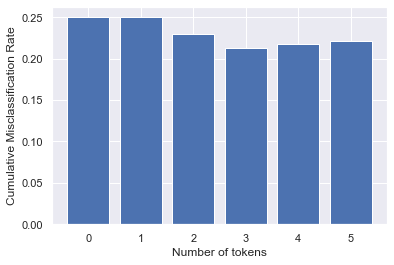

In [100]:
#from the sample, reviews with num_tokens 0, 1, and 5 seem to have the worst rate. 
#However, since the sample for each class is so small, I will assess this data cumulatively...

cumulative = np.cumsum(samp_0['count'])
cum_ms_cls_rate = np.cumsum(samp_0['count'])/np.cumsum(samp_0['total']) #cumulative misclassification rate

plt.bar(x=range(0,6),height=cum_ms_cls_rate)
plt.xlabel('Number of tokens')
plt.ylabel('Cumulative Misclassification Rate')

In [105]:
#It seems that cumulatively, 3 tokens and above will give lower misclassification rates (20% vs ~25% for 0 and 1 tokens)

In [104]:
df_dominant_topic.describe()

,topic_perc_contrib,num_tokens,num_unique_tokens
count,3659.000000,3659.000000,3659.000000
mean,0.693023,13.547691,11.609729
std,0.169194,25.172084,18.668211
min,0.271100,0.000000,0.000000
25%,0.567850,2.000000,2.000000
50%,0.696800,5.000000,5.000000
75%,0.832500,13.000000,13.000000
max,0.995400,333.000000,225.000000


In [108]:
#There appears to be significant class imbalance. However, most reviews are expected to talk about how a game lives up to the series it is from. 
#This was manually verified in the previous sampling.
#will sample assuming equal probability first, seeing as the topics are not all confirmed to be correctly classified.

tokens_df_2 = df_dominant_topic
sample_tokens_df_2 = tokens_df_2.sample(frac=0.1,replace=True,random_state=1337) #sample 10% of my dataset with replacement to ensure that data is independent of each other (covariance = 0) https://web.ma.utexas.edu/users/parker/sampling/repl.htm
sample_tokens_df_2.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
3223,Strategic Gameplay,i like this game but im not sure about the sie...,0.7239,"[im_sure, siege]",2,"[im_sure, siege]",2,"faction, army, diplomacy, vassal, war, player,..."
189,Series Authenticity,Very nice game but needs some fixing.,0.6617,[need],1,[need],1,"three_kingdoms, series, fan, diplomacy, battle..."
860,Series Authenticity,I had never really played a Total War game bef...,0.6003,"[unsure, fps, graphic, ancient_china, care, sh...",12,"[graphic, unsure, shot, refund, request, fps, ...",12,"three_kingdoms, series, fan, diplomacy, battle..."
1256,Tactical Gameplay,"Great graphics, art style and one of the smoot...",0.8454,"[graphic, art_style, gameplay, launch, chinese...",114,"[tactic, naval_combat, duel, compared_previous...",91,"unit, battle, faction, army, general, characte..."
3239,Game Stability,"As a chinese, I think this game has gone deep ...",0.6055,"[romance_three_kingdoms, voice, line, little_b...",27,"[theme, kingdom, fps, gamer, optimization, tw_...",27,"campaign, hour, issue, battle, bug, crash, mul..."


In [109]:
sample_tokens_df_2.to_csv('./dataframes/sample_tokens_df_2.csv')

In [116]:
#import labelled sample_tokens_df

sample_token_mod_df = pd.read_csv('./dataframes/sample_tokens_df_2_mod.csv',index_col=0)

In [117]:
sample_token_mod_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,correct
3223,Strategic Gameplay,i like this game but im not sure about the sie...,0.7239,"['im_sure', 'siege']",2,"['im_sure', 'siege']",2,"faction, army, diplomacy, vassal, war, player,...",0
189,Series Authenticity,Very nice game but needs some fixing.,0.6617,['need'],1,['need'],1,"three_kingdoms, series, fan, diplomacy, battle...",0
860,Series Authenticity,I had never really played a Total War game bef...,0.6003,"['unsure', 'fps', 'graphic', 'ancient_china', ...",12,"['graphic', 'unsure', 'shot', 'refund', 'reque...",12,"three_kingdoms, series, fan, diplomacy, battle...",1
1256,Tactical Gameplay,"Great graphics, art style and one of the smoot...",0.8454,"['graphic', 'art_style', 'gameplay', 'launch',...",114,"['tactic', 'naval_combat', 'duel', 'compared_p...",91,"unit, battle, faction, army, general, characte...",1
3239,Game Stability,"As a chinese, I think this game has gone deep ...",0.6055,"['romance_three_kingdoms', 'voice', 'line', 'l...",27,"['theme', 'kingdom', 'fps', 'gamer', 'optimiza...",27,"campaign, hour, issue, battle, bug, crash, mul...",1


In [131]:
samp_df = sample_token_mod_df.groupby(['num_tokens','correct'],as_index=False).count()[['num_tokens','correct','dominant_topic']]

In [144]:
samp_df.columns = ['num_tokens','correct','count']
count_df1 = samp_df.groupby(['correct'],as_index=False).sum()
count_df1

,correct,num_tokens,count
0,0,348,50
1,1,2395,316


In [146]:
ms_cls_rate2 = count_df1['count'][0]/count_df1['count'][1]
ms_cls_rate2

0.15822784810126583

In [158]:
count_df2 = samp_df[samp_df['num_tokens']>1]
count_df2 = count_df2.groupby(['correct'],as_index=False).sum()
count_df2

,correct,num_tokens,count
0,0,347,35
1,1,2394,270


In [160]:
ms_cls_rate3 = count_df2['count'][0]/count_df2['count'][1]
ms_cls_rate3

0.12962962962962962

In [161]:
count_df3 = samp_df[samp_df['num_tokens']>2]
count_df3 = count_df3.groupby(['correct'],as_index=False).sum()
count_df3

,correct,num_tokens,count
0,0,345,29
1,1,2392,226


In [162]:
ms_cls_rate4 = count_df3['count'][0]/count_df3['count'][1]
ms_cls_rate4

0.12831858407079647

### Findings from the samples

Sample from data with num_tokens <=5:
- The misclassficiation rate of the sample is between 14% and 22%, which I can accept for text analysis...
- For the Internet is dark and full of errors. 
- More seriously, ~80% classification success rate from an unsupervised model seems quite usable. 
- Of course, this is most likely because in the first place, most of the reviews are about Series Authenticity. Most reviews say "Best Total War yet!" or something to that effect.

In any case, the model seems quite usable based on this initial analysis.

Sample from data with any number of tokens:
- The misclassification rate of the sample (10% of the whole dataset) is around 16%, which I find, once again, to be quite acceptable. 
- Given that the sample was was 366 and it was a substantial chunk of the dataset, the rate should be approximately the same for the dataset.
- Long reviews tend to cover multiple topics. To classify one entire review as being about one topic is one way of doing things, but it could mean wasted opportunities...
- When reviews with 1 or 0 tokens are dropped, the misclassification rate drops from ~16% to ~13%.
- When reviews with 2 or fewer tokens are dropped, the misclassification rate drops only very slightly, from 12.9% to 12.8%.
    - The tradeoff is not worth it. A lot more data is lost for only a tiny marginal gain in accuracy of classification.

General:
- The Game Stability topic also includes discussions of general performance and optimisation. Perhaps it should be renamed to Performance & Stability.

**NEXT STEPS**

- Remove reviews that have 0 or 1 tokens from the dataset
- Analyse the entire corpus by sentences instead of by document.
    - This way, there will be more data overall; long reviews can be broken down into parts that talk about different topics. 
- The resulting topics and sentiments can be grouped together for a more accurate overview of player sentiment overall, rather than sentiment for the dominant topic of each document

In [140]:
#rename Game Stability to Performance & Stability
df_dominant_topic['dominant_topic'] = df_dominant_topic['dominant_topic'].replace('Game Stability','Performance & Stability')

#Remove reviews with 1 or 0 tokens

df_dominant_topic2=df_dominant_topic[df_dominant_topic['num_tokens']>1]

#Find out what proportion of reviews were dropped
rows_removed = abs(len(df_dominant_topic)-len(df_dominant_topic2))/len(df_dominant_topic)
print(rows_removed)

0.1434818256354195


In [142]:
#Get number of reviews remaining

len(df_dominant_topic2)

3134

In [143]:
df_dominant_topic.to_csv('./dataframes/dominant_topics.csv')

# Final Validation

After previous sampling, realised that training data should not be used to test the model.

NOTE: Before this section was added, this notebook was thought complete and Sentiment Analysis was done. So, this section includes methodology established in Sentiment Analysis.

In [164]:
request_params = dict()
request_params['filter'] = 'recent'
request_params['language'] = 'english'
request_params['day_range'] = '365'

app_id = 779340
review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=request_params)

[appID = 779340] expected #reviews = 8462


In [189]:
#read in a json file
with open('./data/review_779340_2.json') as jsonfile:
    jayson = json.load(jsonfile)

In [190]:
review_data = [v for v in jayson['reviews'].values()]
author_key_list = list(review_data[0]['author'].keys())

In [191]:
len(review_data)

8422

In [192]:
datetime.datetime.utcfromtimestamp(min([review_data[i]['timestamp_created'] for i in range(len(review_data))])).strftime('%Y-%m-%d')

'2019-05-23'

In [193]:
datetime.datetime.utcfromtimestamp(max([review_data[i]['timestamp_created'] for i in range(len(review_data))])).strftime('%Y-%m-%d')

'2019-07-20'

In [194]:
#previous max value was 1562591773; 2019-07-08
max([review_data[i]['timestamp_created'] for i in range(len(review_data))])

1563618842

In [195]:
#for definition of each field in the JSON files, visit (here)[https://partner.steamgames.com/doc/store/getreviews]

steam_dict = {'recommendationid':[review_data[i]['recommendationid'] for i in range(len(review_data))],
              
              'author_steamid':[review_data[i]['author']['steamid'] for i in range(len(review_data))],
              
              'author_num_games_owned':[review_data[i]['author']['num_games_owned'] for i in range(len(review_data))],
              
              'author_num_reviews':[review_data[i]['author']['num_reviews'] for i in range(len(review_data))],
              
              'author_playtime_forever':[review_data[i]['author']['playtime_forever'] for i in range(len(review_data))], 
              #data recorded in minutes - independently verified: https://steamcommunity.com/id/mydogsnameissnowballball/recommended/730/ - 43586 divided by 724.6h on record = 60 min
              
              'author_playtime_last_two_weeks':[review_data[i]['author']['playtime_last_two_weeks'] for i in range(len(review_data))],
              
              'author_last_played':[review_data[i]['author']['last_played'] for i in range(len(review_data))],
              
              'review':[review_data[i]['review'] for i in range(len(review_data))],
              
              'timestamp_created':[review_data[i]['timestamp_created'] for i in range(len(review_data))],
              
              'timestamp_updated':[review_data[i]['timestamp_updated'] for i in range(len(review_data))],
              
              'voted_up':[review_data[i]['voted_up'] for i in range(len(review_data))],
              
              'weighted_vote_score':[review_data[i]['weighted_vote_score'] for i in range(len(review_data))],
              
              'steam_purchase':[review_data[i]['steam_purchase'] for i in range(len(review_data))],
              
              'received_for_free':[review_data[i]['received_for_free'] for i in range(len(review_data))],
              
              'written_during_early_access':[review_data[i]['written_during_early_access'] for i in range(len(review_data))]}

In [196]:
df_raw = pd.DataFrame(steam_dict)
df_raw.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,54192944,76561198859964653,57,24,1694,1694,1563886009,"Its a chess within a chess, two layers of comp...",1563618842,1563810779,True,0.495412856340408325,True,False,False
1,54192696,76561198433597055,2,1,7441,4943,1563870098,Please give us more Chinese theme game.I will ...,1563617491,1563617491,True,0.523809552192687988,True,False,False


In [197]:
len(df_raw['recommendationid'].unique())

8422

In [198]:
df_raw = df_raw[df_raw['received_for_free']==False] # Redundant for F2P games, because nobody can buy them

In [201]:
df_raw.dtypes

recommendationid                  object
author_steamid                    object
author_num_games_owned             int64
author_num_reviews                 int64
author_playtime_forever            int64
author_playtime_last_two_weeks     int64
author_last_played                 int64
review                            object
timestamp_created                  int64
timestamp_updated                  int64
voted_up                            bool
weighted_vote_score               object
steam_purchase                      bool
received_for_free                   bool
written_during_early_access         bool
dtype: object

In [203]:
df_raw = df_raw[df_raw['timestamp_created']>1562591773]

In [204]:
len(df_raw)

206

In [205]:
df_raw.describe()

,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,timestamp_created,timestamp_updated
count,206.000000,206.000000,206.000000,206.000000,2.060000e+02,2.060000e+02,2.060000e+02
mean,136.820388,12.461165,4731.038835,1242.344660,1.563050e+09,1.563089e+09,1.563102e+09
std,157.885700,20.120514,4680.173901,1543.339617,1.106116e+06,2.940085e+05,3.000377e+05
min,1.000000,1.000000,30.000000,0.000000,1.558703e+09,1.562595e+09,1.562595e+09
25%,36.250000,2.000000,1318.000000,33.500000,1.562953e+09,1.562823e+09,1.562849e+09
50%,96.000000,5.000000,3315.500000,688.000000,1.563451e+09,1.563075e+09,1.563089e+09
75%,179.750000,14.000000,6401.000000,1872.000000,1.563786e+09,1.563361e+09,1.563374e+09
max,1417.000000,142.000000,24184.000000,9085.000000,1.563886e+09,1.563619e+09,1.563811e+09


In [206]:
df_raw['author_playtime_forever']=df_raw['author_playtime_forever']/60
df_raw['author_playtime_last_two_weeks']=df_raw['author_playtime_last_two_weeks']/60

In [207]:
df_raw_num = df_raw.select_dtypes(exclude=['O','bool'])

In [208]:
df_raw_num_high_play = df_raw_num[(df_raw_num['author_playtime_forever']>2) & (df_raw_num['author_playtime_last_two_weeks']>=0.5)]

In [209]:
len(df_raw_num_high_play)

150

In [210]:
df_usable = df_raw[(df_raw['author_playtime_forever']>=3)& (df_raw_num['author_playtime_last_two_weeks']>=(10/60))] #recent opinions are more important, and user must have played longer than refundable playtime cutoff
df_usable.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,54192944,76561198859964653,57,24,28.233333,28.233333,1563886009,"Its a chess within a chess, two layers of comp...",1563618842,1563810779,True,0.495412856340408325,True,False,False
1,54192696,76561198433597055,2,1,124.016667,82.383333,1563870098,Please give us more Chinese theme game.I will ...,1563617491,1563617491,True,0.523809552192687988,True,False,False


In [211]:
review_lengths = [len(x.split()) for x in df_usable['review']]
print(len(review_lengths)) #no of reviews
print(sum(review_lengths)/len(review_lengths)) #mean character length of a review
df_usable['review_length']=df_usable['review'].map(lambda x: len(x.split()))

153
82.359477124183


C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [212]:
df_ready = df_usable[df_usable['review_length']>np.percentile(df_usable['review_length'],25)].reset_index(drop=True) #Remove very short reviews that are likely to be junk

In [214]:
print(min(df_ready['review_length'])) #shortest review length, in words. space-delimited
df_ready.head(2)

12


,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length
0,54183390,76561197984368747,216,6,69.933333,0.300000,1563395139,Awesome. Great game! \n\nDo wish they gave you...,1563562610,1563562610,True,0,False,False,False,80
1,54183023,76561198451245786,155,4,58.450000,2.566667,1563617150,became emperor of china then everyone betrayed...,1563560850,1563560850,True,0,False,False,False,14


In [216]:
#drop duplicate entries in reviews, because they are considered spam
df_cleaning = df_ready.drop_duplicates(subset='review')

In [217]:
df_cleaning.select_dtypes(include='O').describe()

,recommendationid,author_steamid,review,weighted_vote_score
count,111,111,111,111
unique,111,111,111,49
top,54032935,76561198007691650,I'm usually not a fan of total war but this ga...,0
freq,1,1,1,53


In [218]:
deduplicated_rows = abs(len(df_cleaning) - len(df_ready)) #find out how many rows were removed during deduplication
print(deduplicated_rows)
print(deduplicated_rows/len(df_ready)) #Percentage of data that was duplicated

0
0.0


In [221]:
#get languages by document
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
    
def get_lang_doc(text):
    doc = nlp(text)
    return doc._.language['language']

#count languages for sentences in document -- decided not to use this because 1. it slows computation a lot 2. it throws a lot of false positives, especially when splitting short lines
def get_langs_sent(text):
    langs={}
    lang_st={}
    doc = nlp(text)
    
    for i, sent in enumerate(doc.sents):
        langs[i]=sent._.language['language'] #Iterating through sentence level, thus only need to add language. Probability scores should be quite high per sentence.
    
    lang_st = list(set(langs.values())) #Get language code of each language that appeared. As long as more than 1 language appears, the review will be excluded.
    
    return lang_st

In [222]:
#No repeated reviews.

doc_langs = [get_lang_doc(x) for x in df_cleaning['review']] #WARNING: SLOW! May take a couple of minutes to finish.
df_cleaning['review_lang']=doc_langs

In [223]:
df_cleaning.to_csv('./dataframes/vldtn_test_cleaning.csv') #saving so I don't have to run the cleaning operation again

In [224]:
df_cleaning = pd.read_csv('./dataframes/vldtn_test_cleaning.csv',index_col=0)

In [225]:
df_langs_cleaned = df_cleaning[df_cleaning['review_lang']=='en'].reset_index(drop=True)
len(df_langs_cleaned)

111

In [226]:
mult_ln_reviews_dropped = (len(df_cleaning) - len(df_langs_cleaned))/len(df_cleaning)
print(mult_ln_reviews_dropped)

0.0


In [229]:
parser = bbcode.Parser()

def parse(review):
    parsed_text = parser.strip(review)
    return parsed_text

#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [230]:
def parse_sent_tokenize(review):
    
    sent_tokens = [] #store sentence tokens here
    
    text = parse(review)  #remove BBcode first
    
    text = expandContractions(text)
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet. Do not remove stopwords yet.
    text = [word for word in text.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
   
    parsed_text = ' '.join(word for word in text)
    
    doc = nlp(parsed_text)
    for i,sent in enumerate(doc.sents):
        sent_tokens.append(sent.text)
    
    return sent_tokens

#remove punctuation
def remove_punc(sents):
    clean_text = [s.translate(str.maketrans('', '', string.punctuation)) 
                  for s in sents]
    return clean_text

In [232]:
df_langs_cleaned.head(2)

,recommendationid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,review_length,review_lang
0,54183390,76561197984368747,216,6,69.933333,0.300000,1563395139,Awesome. Great game! \n\nDo wish they gave you...,1563562610,1563562610,True,0.0,False,False,False,80,en
1,54183023,76561198451245786,155,4,58.450000,2.566667,1563617150,became emperor of china then everyone betrayed...,1563560850,1563560850,True,0.0,False,False,False,14,en


In [554]:
big_sent_lst =[] #For storing ALL sentences in the dataset. Doesn't matter which reviews they came from

review_index_lst = [] #for storing all index numbers for each sentence so we can identify which reviews they belong to and thus group scores by topics and reviews

sent_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

review_count = 0
for review in df_langs_cleaned['review']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst.extend(sent_tokens)
    
    review_count+=1
    review_num_lst = [str(review_count)] * len(sent_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
    review_index_lst.extend(review_num_lst)

sent_df['original_sent'] = [x for x in big_sent_lst]
sent_df['test_set_review_number'] = review_index_lst
sent_df['token_sentences'] = [x.split() for x in big_sent_lst]

sent_df.head(2)

,original_sent,test_set_review_number,token_sentences
0,awesome,1,[awesome]
1,great game do wish they gave you more factions...,1,"[great, game, do, wish, they, gave, you, more,..."


In [555]:
#load dataset for training ngram phraser

final_data = pd.read_csv('./dataframes/dominant_topics.csv',index_col=0)

In [556]:
final_data.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4715,"['ton', 'diplomacy', 'joke', 'military_access'...",85,"['guess', 'artillery', 'chain', 'siege', 'sent...",57,"unit, battle, faction, army, general, characte..."
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
2,Series Authenticity,Absolutely great game. \nAll the new diplomacy...,0.9391,"['diplomacy_options', 'depth', 'unit_variety',...",10,"['warhammer', 'depth', 'combat', 'rt', 'diplom...",9,"three_kingdoms, series, fan, diplomacy, battle..."
3,Series Authenticity,A fine blend of Warhammer I/II: Total War and ...,0.6487,"['blend', 'warhammer_three', 'shogun_two', 'lo...",20,"['blend', 'warhammer_three', 'character', 'bat...",20,"three_kingdoms, series, fan, diplomacy, battle..."
4,Series Authenticity,Innovative Total Game that has lots of persona...,0.7290,"['personality', 'diplomacy', 'idea', 'combat',...",11,"['art_style', 'paid_dlc', 'combat', 'content',...",10,"three_kingdoms, series, fan, diplomacy, battle..."


In [557]:
#initialise BBcode parser and spacy NLP for parsing and tokenising sentences

nlp = spacy.load("en_core_web_sm")
parser = bbcode.Parser()

def parse(review):
    parsed_text = parser.strip(review)
    return parsed_text

#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [558]:
big_sent_lst2 =[] #For storing ALL sentences in the dataset. Doesn't matter which reviews they came from
train_sent_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst2.extend(sent_tokens)

In [559]:
train_sent_df['original_text'] = [x for x in big_sent_lst2]
train_sent_df['token_sentences'] = [x.split() for x in big_sent_lst2]
train_sent_df.head()

,original_text,token_sentences
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]"
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]"
2,1,[1]
3,diplomacy,[diplomacy]
4,it is joke,"[it, is, joke]"


In [560]:
def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

train_sent_df['sents_unstopped'] = train_sent_df['token_sentences'].map(lambda x: remove_stopwords(x))

bigram = gensim.models.Phrases(list(train_sent_df['sents_unstopped']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to get bigrams]
trigram = gensim.models.Phrases(bigram[list(train_sent_df['sents_unstopped'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#at this point we will make n-grams, then lemmatise using spacy since it can go by permitted postags

def spacy_lemma(bow,allowed_postags=['NOUN']):
    
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ if token.pos_ in allowed_postags else '' for token in lemma_doc]
    
    return lemma_text

In [561]:
#WARNING! this cell can be a little slow, especially with larger datasets (it already takes ~3 minutes with 3600+ rows) -- will consider stemming as a future modification

sent_df['sents_unstopped'] = sent_df['token_sentences'].map(lambda x: remove_stopwords(x))
sent_df['3gram_sentences'] = make_trigrams(sent_df['sents_unstopped'])

en_stopwords.extend(['good','better','great','lot','game','like','I','i','one','two','three','thing','bit','total_war','time'])

sent_df['3gram_sentences_lemma'] = sent_df['3gram_sentences'].map(lambda x: spacy_lemma(x))
sent_df['3gram_sentences_clean'] = sent_df['3gram_sentences_lemma'].map(lambda x: remove_stopwords(x))
sent_df.head(10)

,original_sent,test_set_review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_lemma,3gram_sentences_clean
0,awesome,1,[awesome],[awesome],[awesome],[],[]
1,great game do wish they gave you more factions...,1,"[great, game, do, wish, they, gave, you, more,...","[wish, gave, factions, starting, map, options]","[wish, gave, factions, starting, map, options]","[wish, , faction, , map, option]","[wish, faction, map, option]"
2,the whole bottom of the map is empty which mea...,1,"[the, whole, bottom, of, the, map, is, empty, ...","[map, means, wu, takes, free, territory]","[map, means, wu, takes, free, territory]","[map, , , , , territory]","[map, territory]"
3,really enjoy how romance of the three kingdoms...,1,"[really, enjoy, how, romance, of, the, three, ...","[enjoy, romance, three, kingdoms, lets, play, ...","[enjoy, romance_three_kingdoms, lets, play, wa...","[, romance_three_kingdoms, let, , , , , starti...","[romance_three_kingdoms, let, starting, map, o..."
4,those are minor complaints to great and amazin...,1,"[those, are, minor, complaints, to, great, and...","[minor, complaints, amazing]","[minor, complaints, amazing]","[, complaint, ]",[complaint]
5,my favorite total war series to date and have ...,1,"[my, favorite, total, war, series, to, date, a...","[favorite, total, war, series, date, pretty, p...","[favorite_total_war, series, date, pretty, pla...","[favorite_total_war, series, date, , , medievial]","[favorite_total_war, series, date, medievial]"
6,became emperor of china then everyone betrayed...,2,"[became, emperor, of, china, then, everyone, b...","[emperor, china, betrayed, 1010, reunite, china]","[emperor, china, betrayed, 1010, reunite, china]","[emperor, china, , , reunite, china]","[emperor, china, reunite, china]"
7,graphics you forget what reality is beautiful ...,3,"[graphics, you, forget, what, reality, is, bea...","[graphics, forget, reality, beautiful, decent,...","[graphics, forget, reality, beautiful, decent,...","[graphic, , reality, , , , don‘t, , , paintexe...","[graphic, reality, don‘t, paintexe, gameplay, ..."
8,audience kids teens adults average solitare pl...,3,"[audience, kids, teens, adults, average, solit...","[audience, kids, teens, adults, average, solit...","[audience, kids, teens, adults, average, solit...","[audience, kid, teen, adult, , , player, pc, r...","[audience, kid, teen, adult, player, pc, requi..."
9,decent fast rich boiiiiii ask nasa if they hav...,3,"[decent, fast, rich, boiiiiii, ask, nasa, if, ...","[decent, fast, rich, boiiiiii, ask, nasa, spar...","[decent, fast, rich, boiiiiii, ask, nasa, spar...","[, , , boiiiiii, , nasa, , difficulity, press,...","[boiiiiii, nasa, difficulity, press, ‚, brain,..."


In [562]:
sent_df['num_tokens']=sent_df['3gram_sentences_clean'].map(lambda x: len(x))
sent_df.head()

,original_sent,test_set_review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_lemma,3gram_sentences_clean,num_tokens
0,awesome,1,[awesome],[awesome],[awesome],[],[],0
1,great game do wish they gave you more factions...,1,"[great, game, do, wish, they, gave, you, more,...","[wish, gave, factions, starting, map, options]","[wish, gave, factions, starting, map, options]","[wish, , faction, , map, option]","[wish, faction, map, option]",4
2,the whole bottom of the map is empty which mea...,1,"[the, whole, bottom, of, the, map, is, empty, ...","[map, means, wu, takes, free, territory]","[map, means, wu, takes, free, territory]","[map, , , , , territory]","[map, territory]",2
3,really enjoy how romance of the three kingdoms...,1,"[really, enjoy, how, romance, of, the, three, ...","[enjoy, romance, three, kingdoms, lets, play, ...","[enjoy, romance_three_kingdoms, lets, play, wa...","[, romance_three_kingdoms, let, , , , , starti...","[romance_three_kingdoms, let, starting, map, o...",5
4,those are minor complaints to great and amazin...,1,"[those, are, minor, complaints, to, great, and...","[minor, complaints, amazing]","[minor, complaints, amazing]","[, complaint, ]",[complaint],1


In [563]:
test_sent_df = sent_df[sent_df['num_tokens']>1].reset_index(drop=True)
dropped_rows = abs(len(sent_df)-len(test_sent_df))/len(sent_df)
print(dropped_rows)
print(len(test_sent_df))

0.328
504


In [564]:
#Proportion of test set sentences vs the training set

497/10961

0.04534257823191315

In [565]:
#In hindsight, I should have reserved 20% of the data for testing.

test_sent_df.describe()

,num_tokens
count,504.000000
mean,4.146825
std,2.777048
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,26.000000


In [566]:
test_sent_df.to_csv('./dataframes/vldtn_test_df.csv')

In [567]:
test_sent_df = pd.read_csv('./dataframes/vldtn_test_df.csv',index_col=0)

In [568]:
test_sent_df.head(2)

,original_sent,test_set_review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_lemma,3gram_sentences_clean,num_tokens
0,great game do wish they gave you more factions...,1,"['great', 'game', 'do', 'wish', 'they', 'gave'...","['wish', 'gave', 'factions', 'starting', 'map'...","['wish', 'gave', 'factions', 'starting', 'map'...","['wish', '', 'faction', '', 'map', 'option']","['wish', 'faction', 'map', 'option']",4
1,the whole bottom of the map is empty which mea...,1,"['the', 'whole', 'bottom', 'of', 'the', 'map',...","['map', 'means', 'wu', 'takes', 'free', 'terri...","['map', 'means', 'wu', 'takes', 'free', 'terri...","['map', '', '', '', '', 'territory']","['map', 'territory']",2


In [569]:
test_sent_df.dtypes

original_sent             object
test_set_review_number     int64
token_sentences           object
sents_unstopped           object
3gram_sentences           object
3gram_sentences_lemma     object
3gram_sentences_clean     object
num_tokens                 int64
dtype: object

In [570]:
test_sent_df['token_sentences'] = test_sent_df['token_sentences'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) #n-grams underscores must be preserved for readability
test_sent_df['sents_unstopped'] = test_sent_df['sents_unstopped'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
test_sent_df['3gram_sentences'] = test_sent_df['3gram_sentences'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
test_sent_df['3gram_sentences_clean'] = test_sent_df['3gram_sentences_clean'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 

In [571]:
test_sent_df.head(2)

,original_sent,test_set_review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_lemma,3gram_sentences_clean,num_tokens
0,great game do wish they gave you more factions...,1,"[great, game, do, wish, they, gave, you, more,...","[wish, gave, factions, starting, map, options]","[wish, gave, factions, starting, map, options]","['wish', '', 'faction', '', 'map', 'option']","[wish, faction, map, option]",4
1,the whole bottom of the map is empty which mea...,1,"[the, whole, bottom, of, the, map, is, empty, ...","[map, means, wu, takes, free, territory]","[map, means, wu, takes, free, territory]","['map', '', '', '', '', 'territory']","[map, territory]",2


In [572]:
documents = list(test_sent_df['3gram_sentences_clean'])
dictionary = gensim.corpora.Dictionary(documents)

dictionary.filter_extremes(no_below = 5,no_above=0.5)     

corpus = [dictionary.doc2bow(text) for text in documents]

In [573]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [574]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Content & Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'UX, Performance, Stability',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.Series(test_sent_df['original_sent'])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [575]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [576]:
# Format dataframe
df_sent_dom_topic = df_topic_sents_keywords.reset_index()

df_sent_dom_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens','original_text']

df_sent_dom_topic['num_tokens']=df_sent_dom_topic['tokens'].map(lambda x: len(x))
df_sent_dom_topic['review_number'] = test_sent_df['test_set_review_number']

df_sent_dom_topic = df_sent_dom_topic[['review_number','dominant_topic','original_text','topic_perc_contrib','tokens','num_tokens','keywords']]

# Show dataframe
df_sent_dom_topic.head(5)

,review_number,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,keywords
0,1,Strategic Gameplay,great game do wish they gave you more factions...,0.7929,"[wish, faction, map, option]",4,"faction, army, diplomacy, vassal, war, player,..."
1,1,Strategic Gameplay,the whole bottom of the map is empty which mea...,0.5874,"[map, territory]",2,"faction, army, diplomacy, vassal, war, player,..."
2,1,Strategic Gameplay,really enjoy how romance of the three kingdoms...,0.7243,"[romance_three_kingdoms, let, starting, map, o...",5,"faction, army, diplomacy, vassal, war, player,..."
3,1,Tactical Gameplay,my favorite total war series to date and have ...,0.5686,"[favorite_total_war, series, date, medievial]",4,"unit, battle, faction, army, general, characte..."
4,2,Tactical Gameplay,became emperor of china then everyone betrayed...,0.7038,"[emperor, china, reunite, china]",4,"unit, battle, faction, army, general, characte..."


In [577]:
df_sent_dom_topic.to_csv('./dataframes/vldtn_test_sent_topics.csv')

In [578]:
make_trigrams([['shogun','two','shogun','2']])

[['shogun_two', 'shogun', '2']]

In [579]:
spacy_lemma(['map'])

['']

In [581]:
spacy_lemma(['crashing'])

['']

In [582]:
spacy_lemma(['crash'])

['crash']

In [580]:
df_sent_dom_topic[30:35]

,review_number,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,keywords
30,8,Content & Authenticity,many are very similar and had to constantly ch...,0.3328,"[picture, person]",2,"three_kingdoms, series, fan, diplomacy, battle..."
31,9,Strategic Gameplay,this is the only total war game have not been ...,0.4194,"[finish, week, release, everytime, play, quality]",6,"faction, army, diplomacy, vassal, war, player,..."
32,9,Content & Authenticity,today decided to just uninstall it and move on...,0.3328,"[today, forcing]",2,"three_kingdoms, series, fan, diplomacy, battle..."
33,9,Strategic Gameplay,fan of the era itself or 2 have been too spoil...,0.3606,"[fan, era, spoilt, term, fan, rome, warhammer,...",10,"faction, army, diplomacy, vassal, war, player,..."
34,10,Strategic Gameplay,this game is amazing although the controls wer...,0.7893,"[control, makes_feel, china, chinese_culture, ...",5,"faction, army, diplomacy, vassal, war, player,..."


# Critical mistakes, easy to miss
I made the mistake of feeding my Phraser the wrong list of sentences earlier. I should have fed it the main training set instead of the test set. It did not form n-grams like "best_total_war" at all, which had negative impact when I first checked the data.

Also, more errors:

I have been training the ngram Phraser on the wrong dataset! I applied it correctly when training the LDA Model, but I didn't replicate it correctly when running the bigram Phraser on subsequent models. It did not combine 'shogun' and 'two' to form 'shogun_two' because I didn't take 'one', 'two', and 'three' out of the first run of stopwords each time.

I will take care of these breaking points because the program can still run, but the analysis will be broken due to an incorrectly trained Phraser.

# It's not perfect

SpaCy will read some nouns as verbs or other forms of the word, e.g. "map". It appears as a token in an earlier review, but in a later review the word "map" is missing from tokens.

Could be something to improve, but it could require hard-coding it so that it doesn't output this problem again.